In [1]:
import os
import torch
import numpy as np

import scanpy as sc
from anndata import AnnData

result_dir = "../edges/"
raw_type=False
use_edge=False

In [2]:
def read_data(sample,select=10,loss_threshold=10,exclude_same=True,normalize=False):
    results=torch.load(result_dir+"edges_"+sample+".pth")
    edges=results["attention_score"]
    # modify here
    if normalize:
        attention_score=torch.abs(torch.abs(results["attention_score"])/torch.sum(results["attention_score"],dim=-2,keepdim=True))
    else:
        attention_score=results["attention_score"]
        normalized_attention_score=torch.abs(torch.abs(results["attention_score"])/torch.sum(results["attention_score"],dim=-2,keepdim=True))
    print(attention_score.shape)
    position_x=results["position_x"]
    position_y=results["position_y"]
    cell_type_name=results["cell_type_name"]
    loss1=results["loss_all"].cpu()
    
    B,N=position_x.shape
    loss1=loss1.unsqueeze(dim=-1).repeat(1,select).reshape(-1).numpy()
    
    cell_type_target=[cell_type_name[i][0] for i in range(len(cell_type_name))]
    
    if normalize:
        indices=torch.topk(torch.sum(attention_score,dim=-1),k=select,dim=-1)[1]
        print(torch.topk(torch.mean(attention_score,dim=-1),k=select,dim=-1))
    else:
        tmp=torch.abs(torch.abs(results["attention_score"])/torch.sum(torch.abs(results["attention_score"]),dim=-2,keepdim=True))
        indices=torch.topk(torch.sum(tmp,dim=-1),k=select,dim=-1)[1]
        print(torch.topk(torch.mean(tmp,dim=-1),k=select,dim=-1))
    indices_tmp=torch.arange(0,indices.shape[0],1).unsqueeze(dim=-1).repeat(1,select)
    indices=torch.stack([indices_tmp.reshape(-1),indices.reshape(-1)],dim=0)

    if not use_edge:
        edges=attention_score
        print("not use edge",edges.shape)
    
    edges=edges[indices[0],indices[1],:].reshape(-1,edges.shape[-1]).numpy()
    attention_score=attention_score[indices[0],indices[1],:].reshape(-1,attention_score.shape[-1]).numpy()
    
    to_position_x=position_x[:,0:1].repeat(1,select).reshape(-1).numpy()
    to_position_y=position_y[:,0:1].repeat(1,select).reshape(-1).numpy()
    from_position_x=position_x[:,1:][indices[0],indices[1]].reshape(-1).numpy()
    from_position_y=position_y[:,1:][indices[0],indices[1]].reshape(-1).numpy()
    
    dx=position_x-position_x[:,0:1]
    dy=position_y-position_y[:,0:1]
    distances=torch.sqrt(torch.square(dx)+torch.square(dy))
    distances=distances[indices[0],indices[1]].reshape(-1).numpy()
    
    indices_np=indices.numpy()
    cell_types=np.array(cell_type_name)[:,1:][indices_np[0],indices_np[1]].reshape(B,select)
    print("number of cell types in this sample:",np.unique(np.array(cell_type_name)[:,0],return_counts=True))
    cell_types_pair=[]
    cell_types_target=[]
    flags=[]
    for i in range(cell_types.shape[0]):
        for j in range(cell_types.shape[1]):
            if not raw_type:
                cell_types_pair.append(cell_types[i][j]+"->"+cell_type_target[i])
                flags.append(cell_type_target[i]!=cell_types[i][j])
                cell_types_target.append(cell_type_target[i])
            else:
                cell_types_pair.append(cell_types[i][j].split(" ")[0]+"->"+cell_type_target[i].split(" ")[0])
                flags.append(cell_types[i][j].split(" ")[0]!=cell_type_target[i].split(" ")[0])
                cell_types_target.append(cell_type_target[i].split(" ")[0])

    print(edges.shape,edges[:3,:3])
    adata = AnnData(edges)
    adata.obs['cell_type'] = cell_types_pair
    adata.obs['cell_type_target']=cell_types_target
    adata.obs['from_position_x'] = from_position_x
    adata.obs['from_position_y'] = from_position_y
    adata.obs['to_position_x'] = to_position_x
    adata.obs['to_position_y'] = to_position_y
    adata.obs['distance']=distances
    adata.obs['loss']=loss1
    # modify here
    adata.obsm["y"]=results["y"].repeat(1,select).reshape(results["y"].shape[0]*select,results["y"].shape[1]).numpy()
    adata.obsm["attention_score"]=attention_score
    
    adata=adata[adata.obs['loss']<loss_threshold,:]
    if exclude_same:
        flags=[]
        for pairi in adata.obs['cell_type']:
            name1,name2=pairi.split("->")
            if name1==name2:
                flags.append(False)
            else:
                flags.append(True)
        adata=adata[flags]
    return adata

def plot(adata,color='cell_type',select_type_number=None,select_type=None):
    assert not ((select_type is None and select_type_number is None) and (select_type is not None and select_type_number is not None))
    
    if select_type_number is not None:
        unique=np.unique(adata.obs['cell_type'],return_counts=True)
        args = np.argsort(-unique[1])[:select_type_number]
        select_type = unique[0][args]
    print("selecting edge types:", select_type)
    
    flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
    adata_filtered=adata[flag,:]

    sc.pp.scale(adata_filtered)
    sc.tl.pca(adata_filtered, n_comps=50)
    sc.pp.neighbors(adata_filtered)  # Compute the neighborhood graph
    sc.tl.umap(adata_filtered)  # Compute UMAP
    # Plot UMAP
    sc.pl.umap(adata_filtered, color=color)
    return adata_filtered
    
adata=read_data('Lung12',select=5,exclude_same=True)
print(adata)

torch.Size([69752, 49, 960])
torch.return_types.topk(
values=tensor([[0.3413, 0.0828, 0.0403, 0.0333, 0.0272],
        [0.1807, 0.0866, 0.0851, 0.0481, 0.0432],
        [0.4163, 0.0791, 0.0635, 0.0447, 0.0287],
        ...,
        [0.0638, 0.0516, 0.0467, 0.0463, 0.0426],
        [0.1161, 0.0731, 0.0720, 0.0437, 0.0425],
        [0.1795, 0.0784, 0.0443, 0.0438, 0.0428]]),
indices=tensor([[ 0,  1,  6,  4,  8],
        [ 0,  2, 10,  1,  6],
        [ 0,  4,  2,  1,  3],
        ...,
        [ 4,  1,  6,  2, 38],
        [ 0,  2,  1,  3, 11],
        [ 0,  2, 16, 30,  6]]))
not use edge torch.Size([69752, 49, 960])
number of cell types in this sample: (array(['B-cell', 'NK', 'T CD4 memory', 'T CD4 naive', 'T CD8 memory',
       'T CD8 naive', 'Treg', 'endothelial', 'epithelial', 'fibroblast',
       'mDC', 'macrophage', 'mast', 'monocyte', 'neutrophil', 'pDC',
       'plasmablast', 'tumor 12', 'tumor 13', 'tumor 5', 'tumor 6',
       'tumor 9'], dtype='<U12'), array([ 1344,   556,    27,

selecting edge types: ['neutrophil->fibroblast' 'fibroblast->neutrophil' 'tumor 12->neutrophil'
 'tumor 12->fibroblast' 'neutrophil->tumor 12' 'fibroblast->tumor 12'
 'neutrophil->plasmablast' 'endothelial->fibroblast'
 'plasmablast->neutrophil' 'fibroblast->endothelial']


/tmp/ipykernel_2456370/1493148501.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/

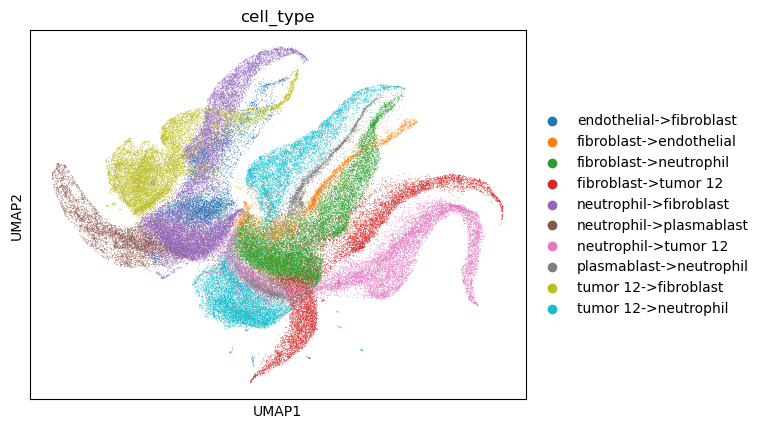

selecting edge types: ['neutrophil->fibroblast' 'fibroblast->neutrophil' 'tumor 12->neutrophil'
 'tumor 12->fibroblast' 'neutrophil->tumor 12' 'fibroblast->tumor 12'
 'neutrophil->plasmablast' 'endothelial->fibroblast'
 'plasmablast->neutrophil' 'fibroblast->endothelial']


/tmp/ipykernel_2456370/1493148501.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


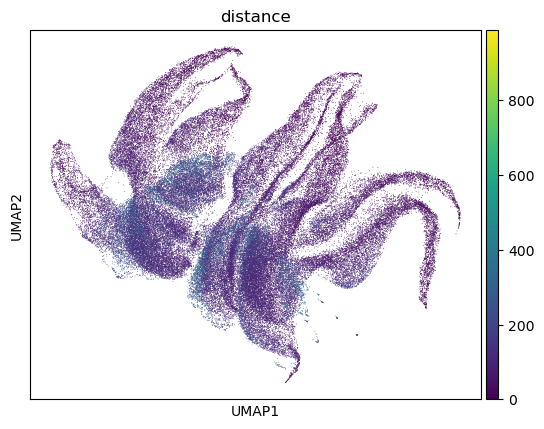

['neutrophil->fibroblast' 'fibroblast->neutrophil' 'tumor 12->neutrophil'
 'tumor 12->fibroblast' 'neutrophil->tumor 12' 'fibroblast->tumor 12'
 'neutrophil->plasmablast' 'endothelial->fibroblast'
 'plasmablast->neutrophil' 'fibroblast->endothelial'
 'endothelial->neutrophil' 'T CD8 naive->fibroblast'
 'T CD4 naive->neutrophil' 'neutrophil->T CD4 naive'
 'neutrophil->endothelial' 'tumor 12->epithelial'
 'T CD4 naive->fibroblast' 'epithelial->tumor 12' 'macrophage->neutrophil'
 'fibroblast->plasmablast' 'mast->fibroblast' 'mDC->fibroblast'
 'T CD8 naive->neutrophil' 'mast->neutrophil' 'fibroblast->T CD8 naive'
 'fibroblast->T CD4 naive' 'endothelial->tumor 12'
 'epithelial->neutrophil' 'tumor 12->plasmablast' 'fibroblast->macrophage'
 'neutrophil->T CD8 naive' 'macrophage->fibroblast'
 'neutrophil->macrophage' 'tumor 5->tumor 12' 'plasmablast->fibroblast'
 'fibroblast->mast' 'B-cell->plasmablast' 'tumor 12->endothelial'
 'NK->neutrophil' 'B-cell->neutrophil' 'endothelial->plasmablast'
 

In [3]:
plot(adata,select_type_number=10)
plot(adata,select_type_number=10,color="distance")
unique=np.unique(adata.obs['cell_type'],return_counts=True)
print(unique[0][np.argsort(-unique[1])],unique[1][np.argsort(-unique[1])])

torch.Size([89091, 49, 960])
torch.return_types.topk(
values=tensor([[0.1616, 0.1165, 0.0667, 0.0476, 0.0457],
        [0.2455, 0.0570, 0.0533, 0.0430, 0.0399],
        [0.2752, 0.1392, 0.0561, 0.0489, 0.0329],
        ...,
        [0.1942, 0.0931, 0.0606, 0.0323, 0.0320],
        [0.1809, 0.1766, 0.0984, 0.0831, 0.0355],
        [0.2194, 0.0969, 0.0574, 0.0489, 0.0388]]),
indices=tensor([[ 0,  1,  4,  7,  2],
        [ 0,  1,  6, 11,  8],
        [ 0,  1,  5,  2,  7],
        ...,
        [ 0, 31,  1,  2, 42],
        [ 1,  0,  3,  2,  6],
        [ 0,  1, 34,  2,  5]]))
not use edge torch.Size([89091, 49, 960])
number of cell types in this sample: (array(['B-cell', 'NK', 'T CD4 memory', 'T CD4 naive', 'T CD8 memory',
       'T CD8 naive', 'Treg', 'endothelial', 'epithelial', 'fibroblast',
       'mDC', 'macrophage', 'mast', 'monocyte', 'neutrophil', 'pDC',
       'plasmablast', 'tumor 12', 'tumor 13', 'tumor 5', 'tumor 6',
       'tumor 9'], dtype='<U12'), array([  481,   177,   606,

/tmp/ipykernel_2456370/1493148501.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/

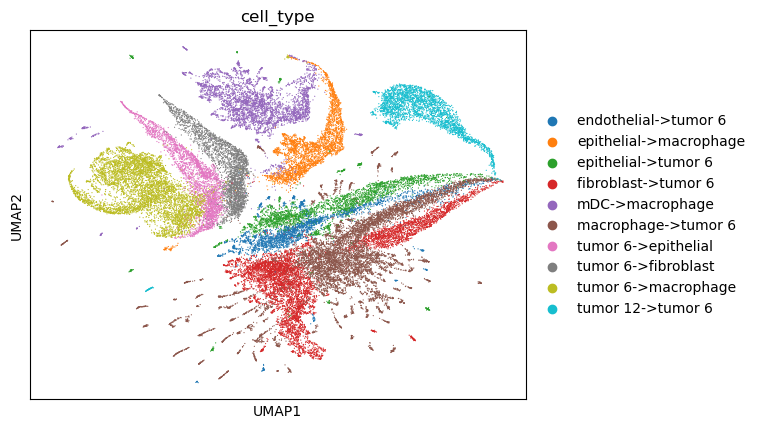

selecting edge types: ['macrophage->tumor 6' 'fibroblast->tumor 6' 'tumor 6->macrophage'
 'mDC->macrophage' 'epithelial->tumor 6' 'tumor 6->epithelial'
 'epithelial->macrophage' 'tumor 6->fibroblast' 'tumor 12->tumor 6'
 'endothelial->tumor 6']


/tmp/ipykernel_2456370/1493148501.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


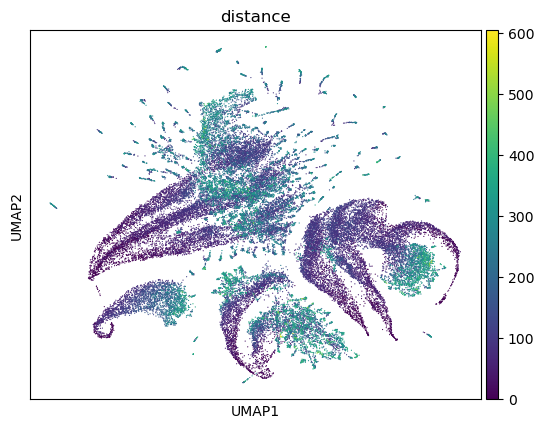

[['macrophage->tumor 6', 'fibroblast->tumor 6', 'tumor 6->macrophage', 'mDC->macrophage', 'epithelial->tumor 6', 'tumor 6->epithelial', 'epithelial->macrophage', 'tumor 6->fibroblast', 'tumor 12->tumor 6', 'endothelial->tumor 6', 'macrophage->epithelial', 'fibroblast->endothelial', 'epithelial->endothelial', 'endothelial->fibroblast', 'endothelial->epithelial', 'neutrophil->tumor 6', 'epithelial->fibroblast', 'fibroblast->macrophage', 'fibroblast->epithelial', 'tumor 6->endothelial', 'macrophage->endothelial', 'macrophage->fibroblast', 'tumor 6->tumor 12', 'macrophage->mDC', 'T CD4 memory->fibroblast', 'monocyte->macrophage', 'endothelial->macrophage', 'T CD8 memory->macrophage', 'tumor 13->tumor 6', 'tumor 6->neutrophil', 'macrophage->T CD8 memory', 'T CD8 memory->tumor 6', 'tumor 9->tumor 6', 'T CD4 memory->tumor 6', 'fibroblast->T CD4 memory', 'T CD4 memory->endothelial', 'T CD4 memory->epithelial', 'NK->tumor 6', 'mast->tumor 6', 'T CD8 memory->epithelial', 'T CD8 naive->endothelia

/tmp/ipykernel_2456370/1493148501.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/

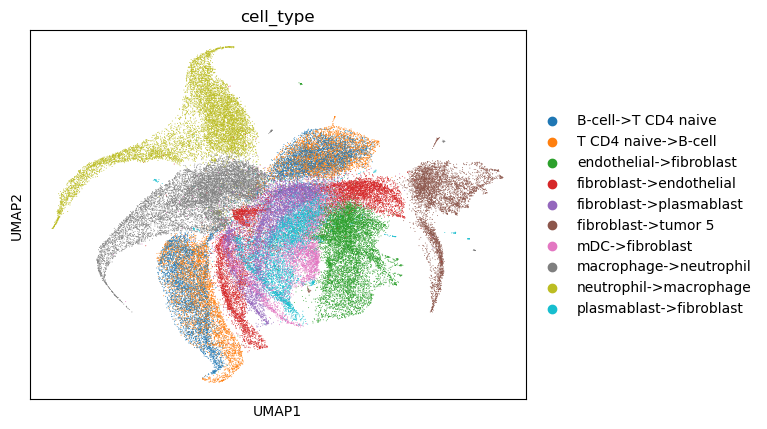

selecting edge types: ['macrophage->neutrophil' 'neutrophil->macrophage'
 'endothelial->fibroblast' 'B-cell->T CD4 naive' 'T CD4 naive->B-cell'
 'fibroblast->endothelial' 'fibroblast->plasmablast'
 'plasmablast->fibroblast' 'fibroblast->tumor 5' 'mDC->fibroblast']


/tmp/ipykernel_2456370/1493148501.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


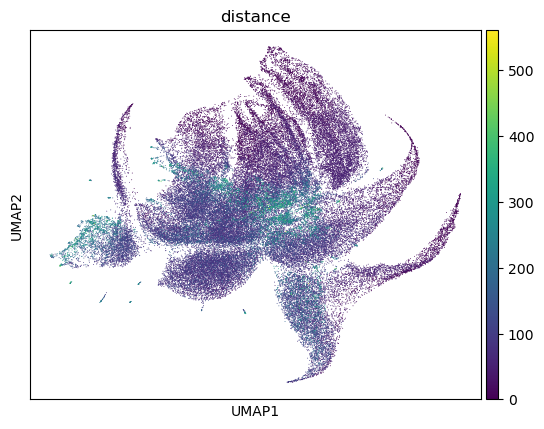

[['macrophage->neutrophil', 'neutrophil->macrophage', 'endothelial->fibroblast', 'B-cell->T CD4 naive', 'T CD4 naive->B-cell', 'fibroblast->endothelial', 'fibroblast->plasmablast', 'plasmablast->fibroblast', 'fibroblast->tumor 5', 'mDC->fibroblast', 'T CD4 naive->fibroblast', 'fibroblast->T CD4 naive', 'fibroblast->mDC', 'pDC->plasmablast', 'monocyte->fibroblast', 'fibroblast->B-cell', 'B-cell->fibroblast', 'plasmablast->pDC', 'endothelial->T CD4 naive', 'tumor 5->neutrophil', 'endothelial->plasmablast', 'fibroblast->neutrophil', 'tumor 5->fibroblast', 'pDC->fibroblast', 'plasmablast->endothelial', 'T CD4 naive->endothelial', 'fibroblast->epithelial', 'epithelial->endothelial', 'fibroblast->macrophage', 'endothelial->neutrophil', 'mast->fibroblast', 'plasmablast->T CD4 naive', 'neutrophil->tumor 5', 'B-cell->plasmablast', 'T CD4 naive->mDC', 'T CD4 naive->plasmablast', 'fibroblast->monocyte', 'plasmablast->B-cell', 'neutrophil->fibroblast', 'tumor 12->tumor 5', 'epithelial->fibroblast'

/tmp/ipykernel_2456370/1493148501.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/

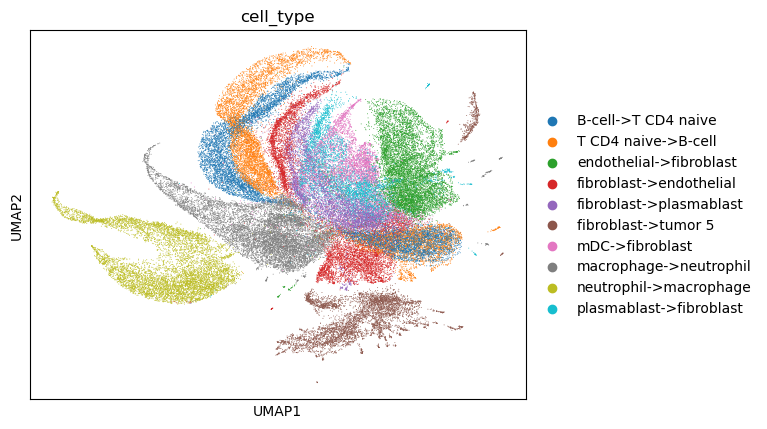

selecting edge types: ['macrophage->neutrophil' 'B-cell->T CD4 naive' 'T CD4 naive->B-cell'
 'endothelial->fibroblast' 'neutrophil->macrophage'
 'fibroblast->endothelial' 'fibroblast->tumor 5' 'fibroblast->plasmablast'
 'plasmablast->fibroblast' 'mDC->fibroblast']


/tmp/ipykernel_2456370/1493148501.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


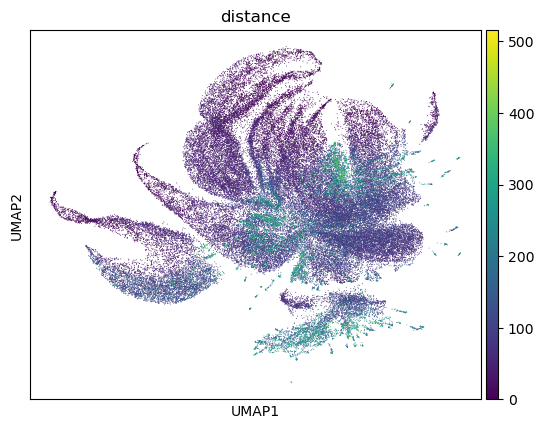

[['macrophage->neutrophil', 'B-cell->T CD4 naive', 'T CD4 naive->B-cell', 'endothelial->fibroblast', 'neutrophil->macrophage', 'fibroblast->endothelial', 'fibroblast->tumor 5', 'fibroblast->plasmablast', 'plasmablast->fibroblast', 'mDC->fibroblast', 'T CD4 naive->fibroblast', 'fibroblast->T CD4 naive', 'fibroblast->mDC', 'pDC->plasmablast', 'fibroblast->B-cell', 'monocyte->fibroblast', 'B-cell->fibroblast', 'endothelial->T CD4 naive', 'endothelial->plasmablast', 'T CD4 naive->endothelial', 'plasmablast->pDC', 'epithelial->endothelial', 'tumor 5->fibroblast', 'pDC->fibroblast', 'T CD4 naive->plasmablast', 'T CD4 naive->mDC', 'plasmablast->T CD4 naive', 'tumor 5->neutrophil', 'plasmablast->endothelial', 'B-cell->plasmablast', 'plasmablast->B-cell', 'fibroblast->neutrophil', 'epithelial->tumor 5', 'monocyte->mDC', 'mast->fibroblast', 'fibroblast->epithelial', 'fibroblast->monocyte', 'T CD8 naive->T CD4 naive', 'endothelial->epithelial', 'fibroblast->macrophage', 'endothelial->neutrophil',

/tmp/ipykernel_2456370/1493148501.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/

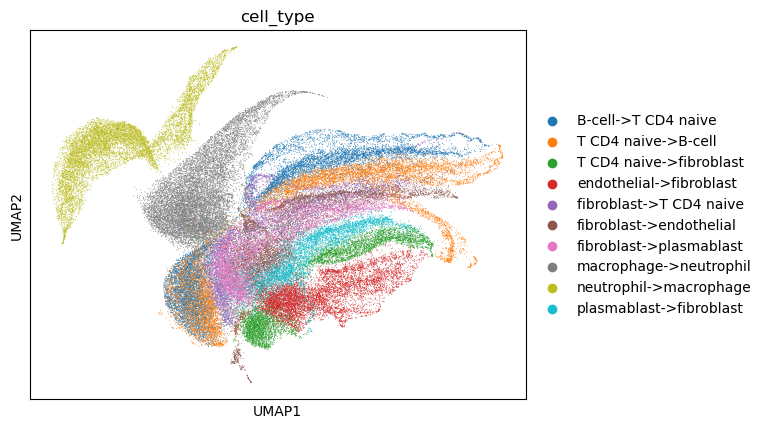

selecting edge types: ['macrophage->neutrophil' 'T CD4 naive->B-cell' 'B-cell->T CD4 naive'
 'neutrophil->macrophage' 'endothelial->fibroblast'
 'fibroblast->endothelial' 'fibroblast->plasmablast'
 'plasmablast->fibroblast' 'T CD4 naive->fibroblast'
 'fibroblast->T CD4 naive']


/tmp/ipykernel_2456370/1493148501.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


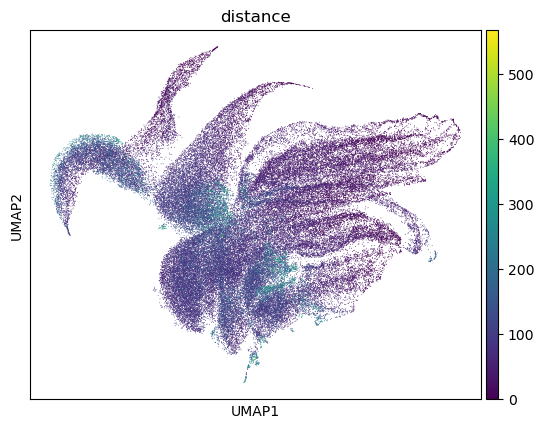

[['macrophage->neutrophil', 'T CD4 naive->B-cell', 'B-cell->T CD4 naive', 'neutrophil->macrophage', 'endothelial->fibroblast', 'fibroblast->endothelial', 'fibroblast->plasmablast', 'plasmablast->fibroblast', 'T CD4 naive->fibroblast', 'fibroblast->T CD4 naive', 'mDC->fibroblast', 'plasmablast->T CD4 naive', 'T CD4 naive->plasmablast', 'fibroblast->tumor 5', 'endothelial->T CD4 naive', 'T CD4 naive->endothelial', 'pDC->plasmablast', 'fibroblast->mDC', 'fibroblast->neutrophil', 'B-cell->fibroblast', 'B-cell->plasmablast', 'endothelial->plasmablast', 'fibroblast->B-cell', 'plasmablast->B-cell', 'plasmablast->endothelial', 'monocyte->fibroblast', 'T CD4 naive->mDC', 'tumor 12->tumor 5', 'endothelial->neutrophil', 'plasmablast->pDC', 'neutrophil->fibroblast', 'neutrophil->tumor 5', 'mDC->T CD4 naive', 'tumor 5->neutrophil', 'tumor 5->fibroblast', 'fibroblast->epithelial', 'pDC->fibroblast', 'mast->fibroblast', 'epithelial->endothelial', 'T CD8 naive->fibroblast', 'plasmablast->neutrophil', 

/tmp/ipykernel_2456370/1493148501.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/

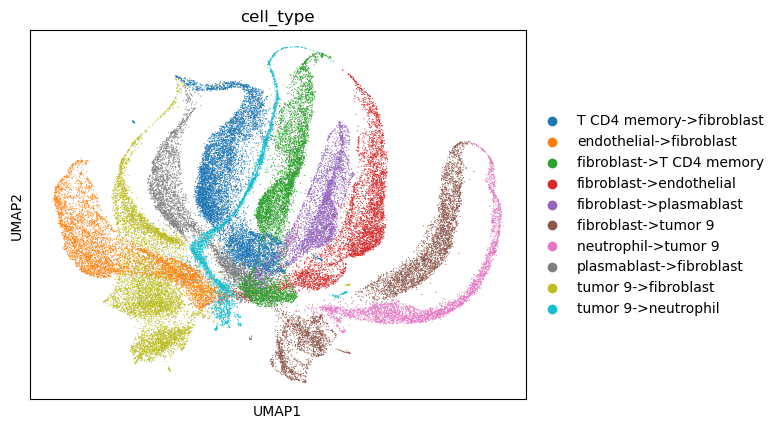

selecting edge types: ['T CD4 memory->fibroblast' 'tumor 9->fibroblast'
 'fibroblast->T CD4 memory' 'endothelial->fibroblast'
 'fibroblast->tumor 9' 'fibroblast->endothelial' 'fibroblast->plasmablast'
 'plasmablast->fibroblast' 'neutrophil->tumor 9' 'tumor 9->neutrophil']


/tmp/ipykernel_2456370/1493148501.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


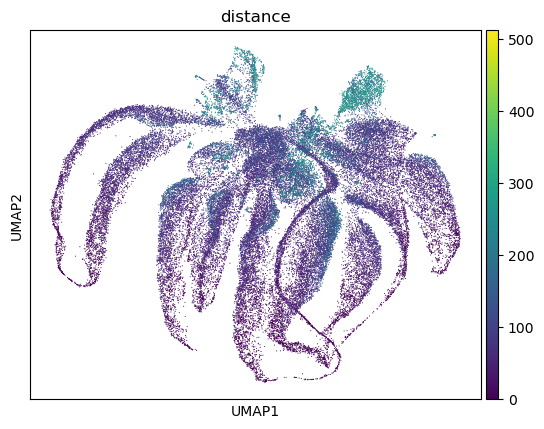

[['T CD4 memory->fibroblast', 'tumor 9->fibroblast', 'fibroblast->T CD4 memory', 'endothelial->fibroblast', 'fibroblast->tumor 9', 'fibroblast->endothelial', 'fibroblast->plasmablast', 'plasmablast->fibroblast', 'neutrophil->tumor 9', 'tumor 9->neutrophil', 'macrophage->tumor 9', 'fibroblast->macrophage', 'macrophage->neutrophil', 'macrophage->fibroblast', 'neutrophil->macrophage', 'epithelial->neutrophil', 'fibroblast->epithelial', 'monocyte->fibroblast', 'epithelial->endothelial', 'epithelial->fibroblast', 'endothelial->epithelial', 'neutrophil->epithelial', 'fibroblast->neutrophil', 'neutrophil->fibroblast', 'T CD8 naive->fibroblast', 'tumor 9->macrophage', 'monocyte->neutrophil', 'neutrophil->endothelial', 'T CD4 memory->endothelial', 'endothelial->neutrophil', 'pDC->fibroblast', 'monocyte->macrophage', 'epithelial->macrophage', 'fibroblast->T CD8 naive', 'fibroblast->Treg', 'fibroblast->monocyte', 'macrophage->epithelial', 'pDC->plasmablast', 'endothelial->T CD4 memory', 'mDC->mac

/tmp/ipykernel_2456370/1493148501.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/

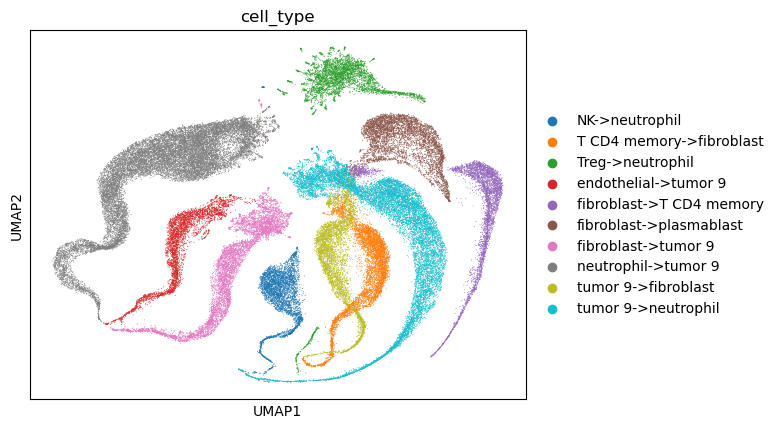

selecting edge types: ['neutrophil->tumor 9' 'tumor 9->neutrophil' 'fibroblast->tumor 9'
 'T CD4 memory->fibroblast' 'fibroblast->plasmablast'
 'tumor 9->fibroblast' 'Treg->neutrophil' 'fibroblast->T CD4 memory'
 'NK->neutrophil' 'endothelial->tumor 9']


/tmp/ipykernel_2456370/1493148501.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


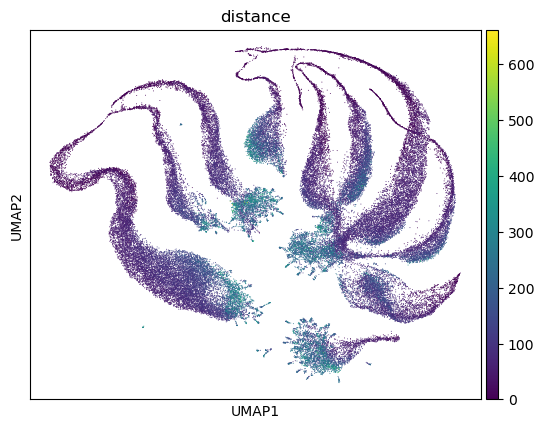

[['neutrophil->tumor 9', 'tumor 9->neutrophil', 'fibroblast->tumor 9', 'T CD4 memory->fibroblast', 'fibroblast->plasmablast', 'tumor 9->fibroblast', 'Treg->neutrophil', 'fibroblast->T CD4 memory', 'NK->neutrophil', 'endothelial->tumor 9', 'fibroblast->endothelial', 'epithelial->tumor 9', 'tumor 6->tumor 9', 'endothelial->fibroblast', 'T CD4 memory->tumor 9', 'pDC->plasmablast', 'macrophage->tumor 9', 'tumor 9->endothelial', 'tumor 9->plasmablast', 'plasmablast->fibroblast', 'T CD8 naive->neutrophil', 'tumor 9->epithelial', 'tumor 12->tumor 9', 'epithelial->neutrophil', 'T CD8 memory->tumor 9', 'endothelial->neutrophil', 'tumor 9->T CD4 memory', 'tumor 12->neutrophil', 'plasmablast->tumor 9', 'Treg->plasmablast', 'T CD4 memory->plasmablast', 'NK->tumor 9', 'fibroblast->neutrophil', 'tumor 9->NK', 'Treg->tumor 9', 'tumor 9->macrophage', 'plasmablast->pDC', 'tumor 9->tumor 12', 'fibroblast->macrophage', 'neutrophil->fibroblast', 'B-cell->neutrophil', 'tumor 9->Treg', 'macrophage->fibrobla

/tmp/ipykernel_2456370/1493148501.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/

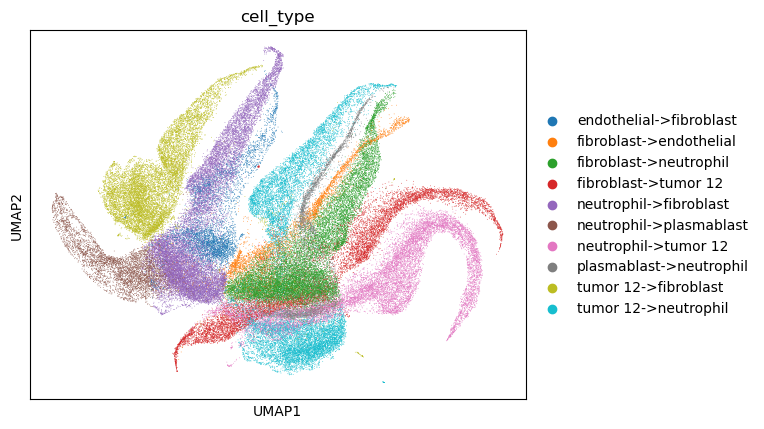

selecting edge types: ['neutrophil->fibroblast' 'fibroblast->neutrophil' 'tumor 12->neutrophil'
 'tumor 12->fibroblast' 'neutrophil->tumor 12' 'fibroblast->tumor 12'
 'neutrophil->plasmablast' 'endothelial->fibroblast'
 'plasmablast->neutrophil' 'fibroblast->endothelial']


/tmp/ipykernel_2456370/1493148501.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


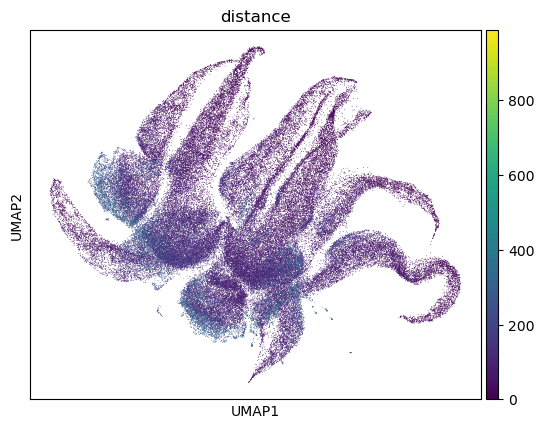

[['neutrophil->fibroblast', 'fibroblast->neutrophil', 'tumor 12->neutrophil', 'tumor 12->fibroblast', 'neutrophil->tumor 12', 'fibroblast->tumor 12', 'neutrophil->plasmablast', 'endothelial->fibroblast', 'plasmablast->neutrophil', 'fibroblast->endothelial', 'endothelial->neutrophil', 'T CD8 naive->fibroblast', 'T CD4 naive->neutrophil', 'neutrophil->T CD4 naive', 'neutrophil->endothelial', 'tumor 12->epithelial', 'T CD4 naive->fibroblast', 'epithelial->tumor 12', 'macrophage->neutrophil', 'fibroblast->plasmablast', 'mast->fibroblast', 'mDC->fibroblast', 'T CD8 naive->neutrophil', 'mast->neutrophil', 'fibroblast->T CD8 naive', 'fibroblast->T CD4 naive', 'endothelial->tumor 12', 'epithelial->neutrophil', 'tumor 12->plasmablast', 'fibroblast->macrophage', 'neutrophil->T CD8 naive', 'macrophage->fibroblast', 'neutrophil->macrophage', 'tumor 5->tumor 12', 'plasmablast->fibroblast', 'fibroblast->mast', 'B-cell->plasmablast', 'tumor 12->endothelial', 'NK->neutrophil', 'B-cell->neutrophil', 'e

/tmp/ipykernel_2456370/1493148501.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/

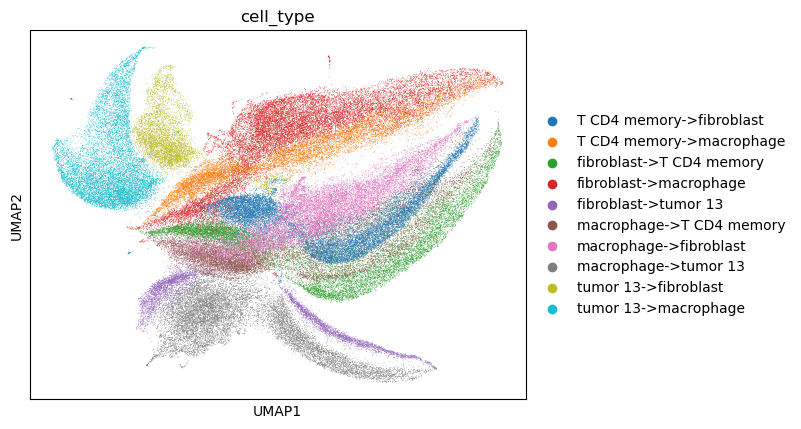

selecting edge types: ['fibroblast->macrophage' 'macrophage->fibroblast'
 'T CD4 memory->fibroblast' 'macrophage->tumor 13'
 'fibroblast->T CD4 memory' 'tumor 13->macrophage'
 'macrophage->T CD4 memory' 'T CD4 memory->macrophage'
 'tumor 13->fibroblast' 'fibroblast->tumor 13']


/tmp/ipykernel_2456370/1493148501.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


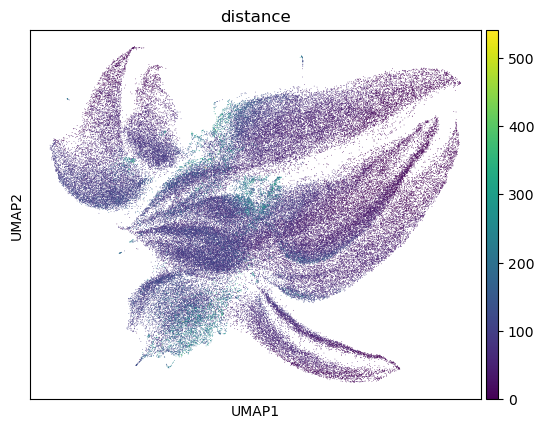

[['fibroblast->macrophage', 'macrophage->fibroblast', 'T CD4 memory->fibroblast', 'macrophage->tumor 13', 'fibroblast->T CD4 memory', 'tumor 13->macrophage', 'macrophage->T CD4 memory', 'T CD4 memory->macrophage', 'tumor 13->fibroblast', 'fibroblast->tumor 13', 'T CD8 memory->macrophage', 'macrophage->T CD8 memory', 'T CD8 memory->tumor 13', 'tumor 13->T CD8 memory', 'tumor 13->T CD4 memory', 'T CD4 memory->tumor 13', 'T CD8 memory->T CD4 memory', 'endothelial->fibroblast', 'Treg->T CD4 memory', 'pDC->fibroblast', 'pDC->T CD4 memory', 'T CD4 memory->Treg', 'T CD4 memory->T CD8 memory', 'T CD4 memory->pDC', 'fibroblast->endothelial', 'mast->fibroblast', 'macrophage->pDC', 'T CD4 memory->mast', 'pDC->macrophage', 'pDC->plasmablast', 'fibroblast->pDC', 'mast->T CD4 memory', 'Treg->fibroblast', 'fibroblast->Treg', 'T CD4 memory->endothelial', 'plasmablast->pDC', 'Treg->macrophage', 'Treg->pDC', 'fibroblast->T CD8 memory', 'macrophage->Treg', 'T CD8 memory->fibroblast', 'fibroblast->mast', 

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
samples=['Lung6', 'Lung5_Rep1', 'Lung5_Rep3', 'Lung5_Rep2', 'Lung9_Rep1', 'Lung9_Rep2', 'Lung12','Lung13']
adata_list=[]
for samplei in samples:
    adata=read_data(samplei,select=5)
    adata_filtered=plot(adata,select_type_number=10)
    plot(adata,color="distance",select_type_number=10)
    adata_list.append(adata)
    
    unique=np.unique(adata.obs['cell_type'],return_counts=True)
    unique=[unique[0][np.argsort(-unique[1])].tolist(),unique[1][np.argsort(-unique[1])].tolist()]
    print(unique)
    torch.save(unique,result_dir+samplei+"_unique_softmax.pth")

merged_adata = sc.concat(adata_list, label="batch")
merged_adata.write('all_3.h5ad')

selecting edge types: ['endothelial->fibroblast' 'fibroblast->endothelial'
 'macrophage->neutrophil' 'fibroblast->plasmablast'
 'neutrophil->macrophage' 'fibroblast->macrophage'
 'T CD4 memory->fibroblast' 'T CD4 naive->B-cell' 'B-cell->T CD4 naive'
 'fibroblast->neutrophil' 'neutrophil->fibroblast'
 'macrophage->fibroblast' 'plasmablast->fibroblast'
 'fibroblast->T CD4 memory' 'neutrophil->tumor 9' 'tumor 12->neutrophil'
 'T CD4 naive->fibroblast' 'mDC->fibroblast' 'pDC->plasmablast'
 'neutrophil->tumor 12']


/tmp/ipykernel_2456370/761914024.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs

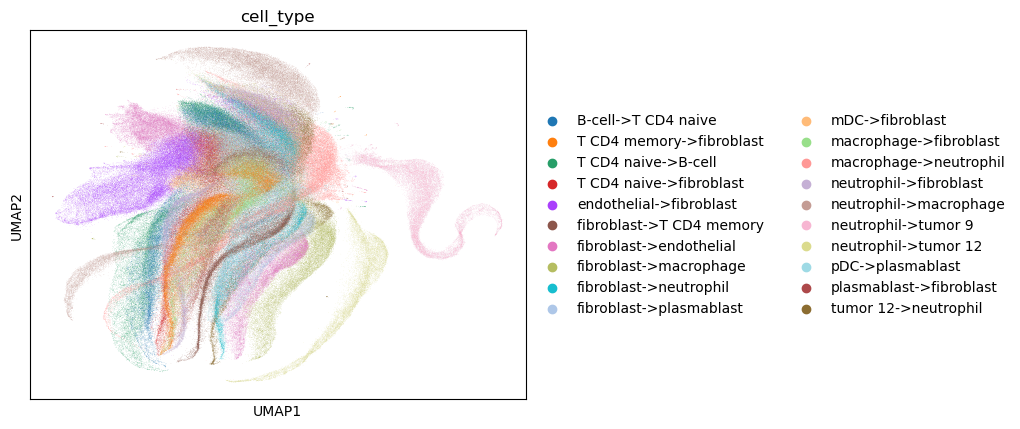

selecting edge types: ['endothelial->fibroblast' 'fibroblast->endothelial'
 'macrophage->neutrophil' 'fibroblast->plasmablast'
 'neutrophil->macrophage' 'fibroblast->macrophage'
 'T CD4 memory->fibroblast' 'T CD4 naive->B-cell' 'B-cell->T CD4 naive'
 'fibroblast->neutrophil']


/tmp/ipykernel_2456370/761914024.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs

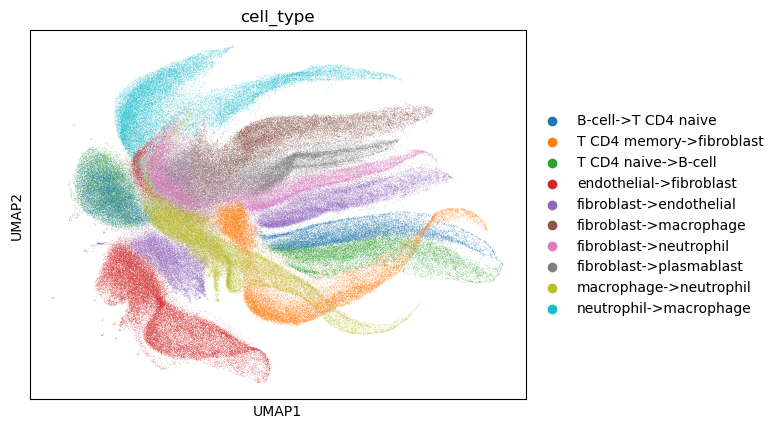

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


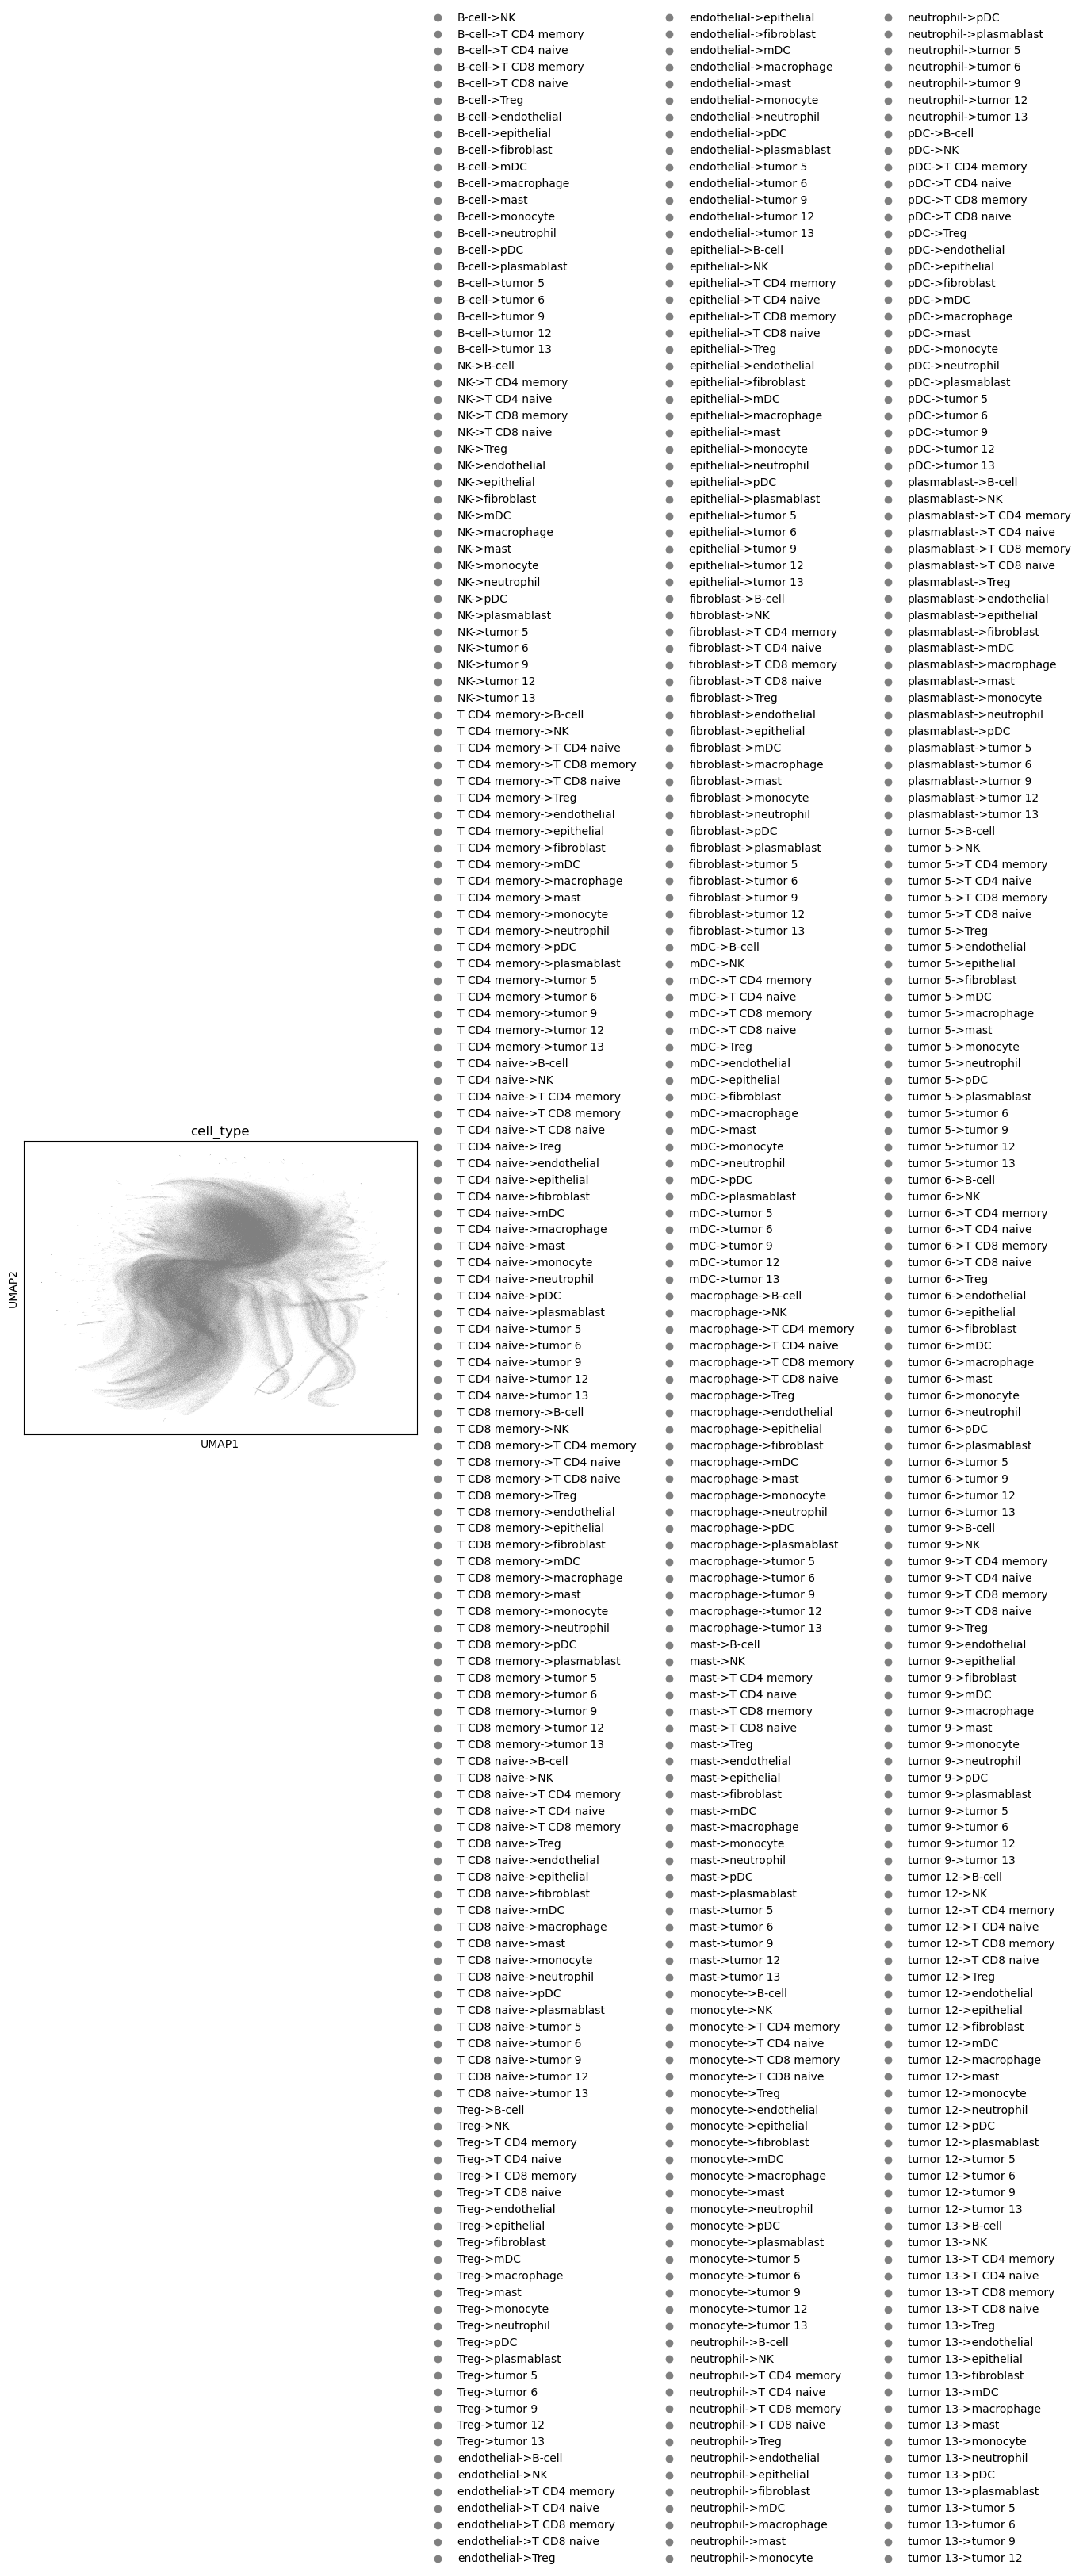

In [5]:
def plot_all(adata,color='cell_type',select_type_number=None):
    if select_type_number is not None:
        unique=np.unique(adata.obs['cell_type'],return_counts=True)
        args = np.argsort(-unique[1])[:select_type_number]
        select_type = unique[0][args]
        print("selecting edge types:", select_type)
        flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
        adata_filtered=adata[flag,:]
    else:
        adata_filtered=adata

    sc.pp.scale(adata_filtered)
    sc.tl.pca(adata_filtered, n_comps=40)
    sc.pp.neighbors(adata_filtered)  # Compute the neighborhood graph
    sc.tl.umap(adata_filtered)  # Compute UMAP
    # Plot UMAP
    sc.pl.umap(adata_filtered, color=color)
    return adata_filtered

merged_adata_filtered20=plot_all(merged_adata,select_type_number=20)
merged_adata_filtered10=plot_all(merged_adata,select_type_number=10)
merged_adata_filtered_all=plot_all(merged_adata,select_type_number=None)
merged_adata_filtered20.write('merged_adata_filtered20_3.h5ad')
merged_adata_filtered10.write('merged_adata_filtered10_3.h5ad')
merged_adata_filtered_all.write('merged_adata_filtered_all_3.h5ad')